In [103]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
#from scipy.stats import gaussian_kde


In [ ]:
# Replace with your actual folder paths
adata1 = sc.read_10x_h5("SSTX-Huh7/outs/filtered_feature_bc_matrix.h5")
adata2 = sc.read_10x_h5("SSTX-DENV2/outs/filtered_feature_bc_matrix.h5")

print(adata1.shape)
print(adata2.shape)

for adatas in [adata1, adata2]:
    adatas.var["gene_name"] = adatas.var.index.copy()
    adatas.var.set_index('gene_ids', inplace=True)
    adatas.var.index.name = None

# Combine datasets and label batches
adata = ad.concat([adata1, adata2], 
   label="source", 
   keys=["Huh7", "Huh7-DENV2"],
   join="outer",
   index_unique=None
   )

adata.var["gene_ids"] = adata.var.index.copy()

In [ ]:
# Specify the path to the GTF file
gtf_file = "filtered_gene_id_biotypes.csv"

# Read the CSV file into a DataFrame
gtf_data = pd.read_csv(gtf_file)

gtf_data = gtf_data.drop_duplicates(subset='gene_id', keep='first')

# Function to append biotype to adata
def append_biotype(adata, gtf_data):
    # Ensure compatibility of gene_ids column
    adata.var = adata.var.copy()  # Avoid potential warnings about chained assignments
    adata.var["gene_ids"] = adata.var["gene_ids"].astype(str)
    gtf_data["gene_id"] = gtf_data["gene_id"].astype(str)
    
    # Merge on gene_ids and gene_id
    merged_var = adata.var.merge(
        gtf_data[["gene_id", "gene_name", "biotype"]],  # Only include relevant columns
        left_on="gene_ids",                # Match adata.var['gene_ids'] with gtf_data['gene_id']
        right_on="gene_id",
        how="left"
    )
    
    # Add biotype back to adata.var
    adata.var = merged_var
    
    # Fill missing biotype entries with "unknown"
    adata.var["biotype"] = adata.var["biotype"].fillna("unknown")
    
    return adata


# Apply the function to each AnnData object in the list
adata = append_biotype(adata, gtf_data)

adata.var.set_index('gene_name', inplace=True)
adata.var.index.name = None

In [ ]:
adata.obs_names_make_unique()
sc.pp.filter_cells(adata, min_genes=300)
#sc.pp.filter_genes(adata, min_cells=3)

# Subset to protein-coding genes
protein_coding_mask = adata.var['biotype'] == 'protein_coding'
protein_adata = adata[:, protein_coding_mask].copy()

sc.pp.scrublet(protein_adata, batch_key="source")

adata.obs['doublet_score'] = protein_adata.obs['doublet_score']
adata.obs['predicted_doublet'] = protein_adata.obs['predicted_doublet']

In [ ]:
adata.write("DENV2_combined_raw_scrublet.h5ad")

In [104]:
# Load the AnnData object from the .h5ad file
adata = sc.read("DENV2_combined_raw_scrublet.h5ad")

/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [105]:
threshold = 0.18 #0.18  # Adjust based on your expectations

# Flag high doublet score cells
adata.obs['high_doublet_score'] = adata.obs['doublet_score'] > threshold

# Group by batch (adjust 'batch' to match your actual column name)
batch_col = 'source'  # replace with the name of your batch column

# Compute doublet rate per batch
doublet_stats = (
    adata.obs
    .groupby(batch_col)
    .apply(lambda df: pd.Series({
        'total_cells': df.shape[0],
        'doublet_cells': df['high_doublet_score'].sum(),
        'doublet_rate': df['high_doublet_score'].mean()
    }))
)

# Print nicely
for batch, row in doublet_stats.iterrows():
    print(f"Batch: {batch}")
    print(f"  Total cells: {int(row['total_cells'])}")
    print(f"  Doublet cells: {int(row['doublet_cells'])}")
    print(f"  Doublet rate: {row['doublet_rate']:.2%}\n")


Batch: Huh7
  Total cells: 30289
  Doublet cells: 3593
  Doublet rate: 11.86%

Batch: Huh7-DENV2
  Total cells: 9803
  Doublet cells: 394
  Doublet rate: 4.02%



/tmp/ipykernel_22874/1398911906.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(batch_col)
/tmp/ipykernel_22874/1398911906.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


In [106]:
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

sc.pp.calculate_qc_metrics(
    adata, inplace=True, log1p=True
)

# Identify and calculate mitochondrial content
mt_gene_mask = adata.var_names.str.startswith(('MT-', 'mt-'))
mt_count = np.sum(mt_gene_mask)
print(f"Found {mt_count} mitochondrial genes")
if mt_count > 0:
    adata.var['mt'] = mt_gene_mask
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print("Mitochondrial metrics calculated.")
else:
    print("No mitochondrial genes found with standard prefixes.")
    adata.obs['pct_counts_mt'] = 0

/home/users/isakova/.local/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


Found 35 mitochondrial genes
Mitochondrial metrics calculated.


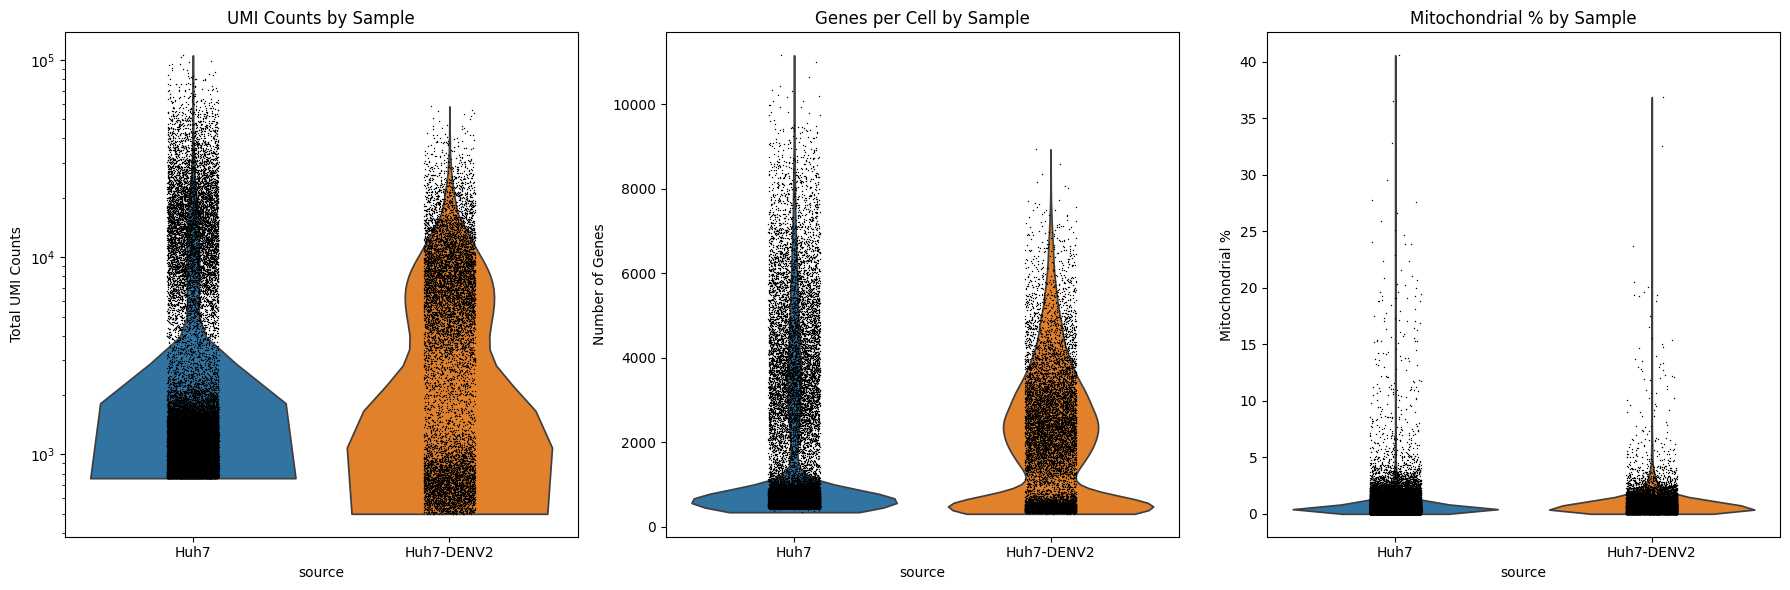

In [107]:
# Visualize QC metrics by sample to identify batch effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# UMI counts by batch
sc.pl.violin(adata, 'total_counts', groupby='source', ax=axes[0], show=False)
axes[0].set_title('UMI Counts by Sample')
axes[0].set_ylabel('Total UMI Counts')
axes[0].set_yscale('log')

# Genes per cell by batch
sc.pl.violin(adata, 'n_genes_by_counts', groupby='source', ax=axes[1], show=False)
axes[1].set_title('Genes per Cell by Sample')
axes[1].set_ylabel('Number of Genes')

# Mitochondrial % by batch
sc.pl.violin(adata, 'pct_counts_mt', groupby='source', ax=axes[2], show=False)
axes[2].set_title('Mitochondrial % by Sample')
axes[2].set_ylabel('Mitochondrial %')
plt.tight_layout()
plt.show()

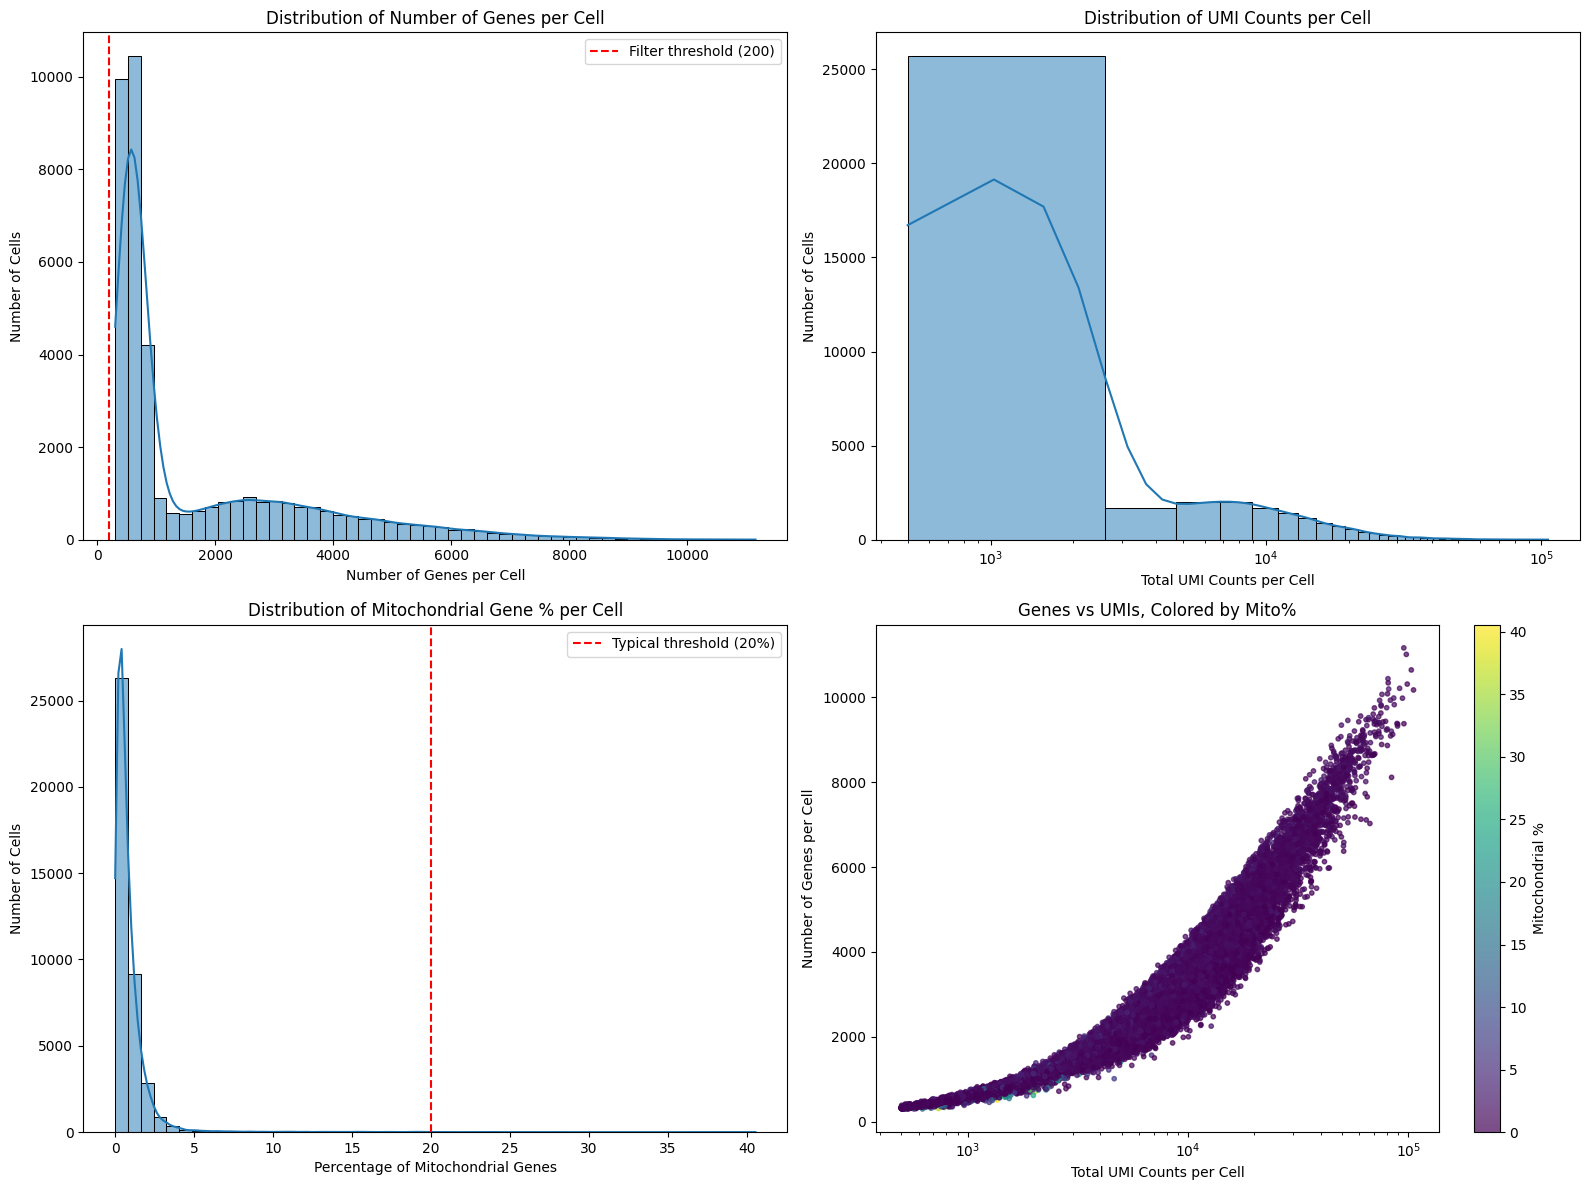

In [108]:
import seaborn as sns
# Visualize QC metrics 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Distribution of genes per cell
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('Number of Genes per Cell')
axes[0, 0].set_ylabel('Number of Cells')
axes[0, 0].set_title('Distribution of Number of Genes per Cell')
axes[0, 0].axvline(200, color='red', linestyle='--', label='Filter threshold (200)')
axes[0, 0].legend()

# Distribution of UMI counts per cell
sns.histplot(adata.obs['total_counts'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Total UMI Counts per Cell')
axes[0, 1].set_ylabel('Number of Cells')
axes[0, 1].set_title('Distribution of UMI Counts per Cell')
axes[0, 1].set_xscale('log')

# Distribution of mitochondrial gene percentage
sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Percentage of Mitochondrial Genes')
axes[1, 0].set_ylabel('Number of Cells')
axes[1, 0].set_title('Distribution of Mitochondrial Gene % per Cell')
axes[1, 0].axvline(20, color='red', linestyle='--', label='Typical threshold (20%)')
axes[1, 0].legend()

# Scatter plot of UMI count vs genes per cell colored by mito percent
scatter = axes[1, 1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], c=adata.obs['pct_counts_mt'], cmap='viridis', s=10, alpha=0.7)
axes[1, 1].set_xlabel('Total UMI Counts per Cell')
axes[1, 1].set_ylabel('Number of Genes per Cell')
axes[1, 1].set_title('Genes vs UMIs, Colored by Mito%')
axes[1, 1].set_xscale('log')
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Mitochondrial %')
plt.tight_layout()
plt.show()

In [109]:
adata.layers["counts"] = adata.X.copy()

In [110]:
max_mito = 5##  5  # Maximum percentage of mitochondrial genes (adjust based on your data)
max_counts = 7000  # Maximum UMI counts 
min_counts = 1000 #1000

print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Filter cells based on QC metrics
adata = adata[(adata.obs['n_genes_by_counts'] <= max_counts) & (adata.obs['n_genes_by_counts'] >= min_counts) & (adata.obs['pct_counts_mt'] <= max_mito)]

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")

Before filtering: 40092 cells, 46083 genes
After filtering: 14419 cells, 46083 genes


In [111]:
# Remove doublets
adata = adata[adata.obs["doublet_score"] < 0.18].copy() # 0.18

In [113]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [114]:
# Step 1: Create a temporary AnnData with only protein-coding genes
adata_protein_coding = adata[:, adata.var["biotype"] == "protein_coding"]
adata_protein_coding.var

# Step 2: Identify highly variable genes among protein-coding genes
sc.pp.highly_variable_genes(adata_protein_coding,batch_key="source")

# Step 3: Transfer HVG labels back to the full dataset
adata.var["highly_variable"] = False  # Set all to False initially
adata.var.loc[adata_protein_coding.var_names[adata_protein_coding.var["highly_variable"]], "highly_variable"] = True
# Preprocessing steps (if not already done)
adata.raw = adata



/home/users/isakova/.local/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:700: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


## Viral load score

In [115]:
viral_rna = ['sfRNA1','sfRNA2','sfRNA3','sfRNA4', "POLY"]
sc.tl.score_genes(adata, gene_list=viral_rna, score_name='viral_load_score')

sfrna_rna = ['sfRNA1','sfRNA2','sfRNA3','sfRNA4']
sc.tl.score_genes(adata, gene_list=sfrna_rna, score_name='sfrna_load')

In [116]:
adata.obs['viral_load'] = adata[:, ['sfRNA1','sfRNA2','sfRNA3','sfRNA4', "POLY"]].X.sum(axis=1).A.flatten()
adata.obs['viral_pct'] = adata.obs['viral_load'] / adata.obs['total_counts'] * 100


## CC score

In [117]:
# Human cell cycle genes from Tirosh et al. 2016
s_genes = [
    'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2',
    'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2', 'RPA2',
    'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3',
    'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN',
    'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1',
    'E2F8'
]

g2m_genes = [
    'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80',
    'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A',
    'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E',
    'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
    'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
    'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
    'CTCF', 'NEK2'
]


s_genes_use = [g for g in s_genes if g in adata.var_names]
g2m_genes_use = [g for g in g2m_genes if g in adata.var_names]

# Run cell cycle scoring
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_use, g2m_genes=g2m_genes_use)

## Scale, PCA, UMAP

In [118]:
sc.pp.scale(adata)
sc.pp.pca(adata,random_state=0)
sc.pp.neighbors(adata,random_state=0)
sc.tl.umap(adata,random_state=0)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=.1,random_state=0)  # Adjust resolution based on your dataset

In [ ]:
sc.pl.umap(
    adata,
    color=["source"],
    wspace=0.5,
    size=13,
)
sc.pl.umap(
    adata,
    color=["leiden"],
    # increase horizontal space between panels
    legend_loc='on data',
    wspace=0.5,
    size=13,
)
sc.pl.umap(
    adata,
    color=["sfRNA1", "sfRNA4","sfRNA2", "sfRNA3", "POLY"],
    # increase horizontal space between panels
    wspace=0.5,
    size=10,
)


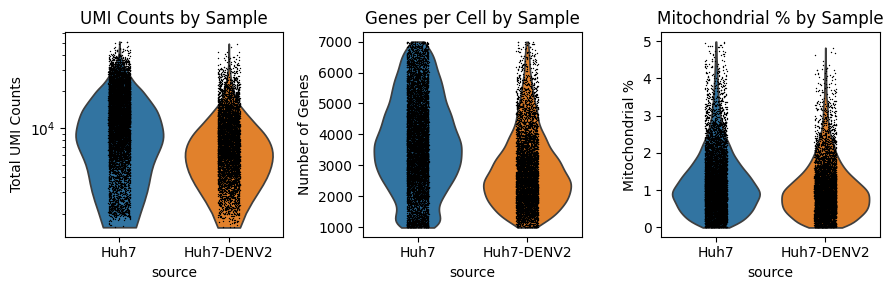

In [20]:
# Visualize QC metrics by sample to identify batch effects
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# UMI counts by batch
sc.pl.violin(adata, 'total_counts', groupby='source', ax=axes[0], show=False)
axes[0].set_title('UMI Counts by Sample')
axes[0].set_ylabel('Total UMI Counts')
axes[0].set_yscale('log')

# Genes per cell by batch
sc.pl.violin(adata, 'n_genes_by_counts', groupby='source', ax=axes[1], show=False)
axes[1].set_title('Genes per Cell by Sample')
axes[1].set_ylabel('Number of Genes')

# Mitochondrial % by batch
sc.pl.violin(adata, 'pct_counts_mt', groupby='source', ax=axes[2], show=False)
axes[2].set_title('Mitochondrial % by Sample')
axes[2].set_ylabel('Mitochondrial %')
plt.tight_layout()
#plt.savefig("DENV2_stats.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Plot CC score, viral load for figure

In [ ]:
# Set figure size (width, height in inches); make it small and square
fig = sc.pl.umap(adata, color=['phase'], wspace=0.5,
    size=10, show=False, frameon=False)

fig = plt.gcf()
fig.set_size_inches(4, 4)  # Set to desired width, height in inches

plt.tight_layout()
#plt.savefig("umap_dengue_plot_cc.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Split adata to adatad (Huh7-DENV2)

In [125]:
adatad = adata[adata.obs['source'] == 'Huh7-DENV2'].copy()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom gray-to-red colormap
gray_red_cmap = LinearSegmentedColormap.from_list("gray_red", ["lightgray", "#a9373b"])

# Set figure size (width, height in inches); make it small and square
fig = sc.pl.umap(adatad, color=['sfrna_load', "POLY"], wspace=0.5,
    size=10, show=False, frameon=False,
    layer=None, use_raw=True,cmap=gray_red_cmap)

fig = plt.gcf()
fig.set_size_inches(8, 4)  # Set to desired width, height in inches

plt.suptitle("sfRNA Load (sfRNA1-4)", fontsize=12)
plt.tight_layout()
plt.show()


In [33]:
adatad.write("DENV2_adatad.h5ad")